In [1]:
from time import time

nb_start_time = time()

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as DL
from torch.nn.utils import weight_norm as WN
import torch.nn.functional as F

from time import time
import random as r

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, log_loss

In [3]:
def breaker():
    print("\n" + 30 * "-" + "\n")
    
def head(x=None, no_of_ele=5):
    breaker()
    print(x[:no_of_ele])
    breaker()
    
def getCol(x=None):
    return [col for col in x.columns]

def getObj(x=None):
    s = (x.dtypes == "object")
    return list(s[s].index)

def preprocess(x=None, *args):
    df = x.copy()
    df[args[0]]  = df[args[0]].map({'Female' : 0, 'Male' : 1})
    df[args[1]]  = df[args[1]].map({'No' : 0, 'Yes' : 1})
    df[args[2]]  = df[args[2]].map({'No' : 0, 'Yes' : 1})
    df[args[3]]  = df[args[3]].map({'No' : 0, 'Yes' : 1})
    df[args[4]]  = df[args[4]].map({'No' : 0, 'Yes' : 1})
    df[args[5]]  = df[args[5]].map({'No' : 0, 'Yes' : 1})
    df[args[6]]  = df[args[6]].map({'No' : 0, 'Yes' : 1})
    df[args[7]]  = df[args[7]].map({'No' : 0, 'Yes' : 1})
    df[args[8]]  = df[args[8]].map({'No' : 0, 'Yes' : 1})
    df[args[9]]  = df[args[9]].map({'No' : 0, 'Yes' : 1})
    df[args[10]] = df[args[10]].map({'No' : 0, 'Yes' : 1})
    df[args[11]] = df[args[11]].map({'No' : 0, 'Yes' : 1})
    df[args[12]] = df[args[12]].map({'No' : 0, 'Yes' : 1})
    df[args[13]] = df[args[13]].map({'No' : 0, 'Yes' : 1})
    df[args[14]] = df[args[14]].map({'No' : 0, 'Yes' : 1})
    df[args[15]] = df[args[15]].map({'Negative' : 0, 'Positive' : 1})
    return df

mms = MinMaxScaler(feature_range=(0,1), copy=True)
sc  = StandardScaler()

In [4]:
data = pd.read_csv("../input/earlystagediabetesriskpredictiondataset/diabetes_data_upload.csv")

breaker()
print("Dataset Shape :", repr(data.shape))
breaker()
for name in getCol(data):
    print(name)
breaker()

data = preprocess(data, 'Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss',
                  'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring',
                  'Itching', 'Irritability', 'delayed healing', 'partial paresis',
                  'muscle stiffness', 'Alopecia', 'Obesity','class')

labels   = data.iloc[:, -1].copy().values
features = data.iloc[:, :-1].copy().values

X, X_test, y, y_test = train_test_split(features, labels, test_size=120, shuffle=True, random_state=0)

NUM_FEATURES = X.shape[1]


------------------------------

Dataset Shape : (520, 17)

------------------------------

Age
Gender
Polyuria
Polydipsia
sudden weight loss
weakness
Polyphagia
Genital thrush
visual blurring
Itching
Irritability
delayed healing
partial paresis
muscle stiffness
Alopecia
Obesity
class

------------------------------



In [5]:
class DS(Dataset):
    def __init__(this, X=None, y=None, mode="train"):
        this.mode = mode
        this.X = X
        if mode == "train":
            this.y = y
            
    def __len__(this):
        return this.X.shape[0]
    
    def __getitem__(this, idx):
        if this.mode == "train":
            return torch.FloatTensor(this.X[idx]), torch.FloatTensor(this.y[idx])
        else:
            return torch.FloatTensor(this.X[idx])

In [6]:
class CFG():
    tr_batch_size = 32
    va_batch_size = 32
    ts_batch_size = 32
    
    epochs  = 50
    n_folds = 4
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    IL = NUM_FEATURES
    HL_1 = [64]
    HL_2 = [64, 64]
    OL = 1
    
cfg = CFG()

ts_data_setup = DS(X_test, None, "test")
ts_data = DL(ts_data_setup, batch_size=cfg.ts_batch_size, shuffle=False)

In [7]:
class MLP(nn.Module):
    def __init__(this, IL=None, HL=None, OL=None):
        super(MLP, this).__init__()
        
        this.HL = HL
        this.DP1 = nn.Dropout(p=0.2)
        this.DP2 = nn.Dropout(p=0.5)
        
        if len(HL) == 1:
            this.BN1 = nn.BatchNorm1d(IL)
            this.FC1 = WN(nn.Linear(IL, HL[0]))
            
            this.BN2 = nn.BatchNorm1d(HL[0])
            this.FC2 = WN(nn.Linear(HL[0], OL))
        
        elif len(HL) == 2:
            this.BN1 = nn.BatchNorm1d(IL)
            this.FC1 = WN(nn.Linear(IL, HL[0]))
            
            this.BN2 = nn.BatchNorm1d(HL[0])
            this.FC2 = WN(nn.Linear(HL[0], HL[1]))
            
            this.BN3 = nn.BatchNorm1d(HL[1])
            this.FC3 = WN(nn.Linear(HL[1], OL))
            
        else:
            raise NotImplementedError("Only Supports Networks of Depth 1 or 2")
            
    def getOptimizer(this, lr=1e-3, wd=0):
        return optim.Adam(this.parameters(), lr=lr, weight_decay=wd)
    
    def forward(this, x):
        if len(this.HL) == 1:
            x = this.BN1(x)
            x = this.DP1(x)
            x = F.relu(this.FC1(x))
            x = this.BN2(x)
            x = this.DP2(x)
            x = this.FC2(x)
            return x
        else:
            x = this.BN1(x)
            x = this.DP1(x)
            x = F.relu(this.FC1(x))
            x = this.BN2(x)
            x = this.DP2(x)
            x = F.relu(this.FC2(x))
            x = this.BN3(x)
            x = this.DP2(x)
            x = this.FC3(x)
            return x

In [8]:
def train_fn(X=None, y=None, n_folds=None, HL_Used=None):
    breaker()
    print("Training ...")
    breaker()
    
    LP = []
    names = []
    
    bestLoss = {"train" : np.inf, "valid" : np.inf}
    fold = 0
    
    start_time = time()
    for tr_idx, va_idx in KFold(n_splits=n_folds, shuffle=True, random_state=0).split(X, y):
        print("Processing Fold {fold} ...".format(fold=fold+1))
        
        X_train, X_valid, y_train, y_valid = X[tr_idx], X[va_idx], y[tr_idx], y[va_idx]
        
        tr_data_setup = DS(X_train, y_train.reshape(-1,1))
        va_data_setup = DS(X_valid, y_valid.reshape(-1,1))
        
        DLS = {"train" : DL(tr_data_setup, batch_size=cfg.tr_batch_size, shuffle=True, generator=torch.manual_seed(0)),
               "valid" : DL(va_data_setup, batch_size=cfg.va_batch_size, shuffle=False)
              }
        
        torch.manual_seed(0)
        model = MLP(cfg.IL, HL_Used, cfg.OL)
        model.to(cfg.device)
        
        optimizer = model.getOptimizer()
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, eps=1e-6, verbose=True)
        
        for e in range(cfg.epochs):
            epochLoss = {"train" : 0, "valid" : 0}
            for phase in ["train", "valid"]:
                if phase == "train":
                    model.train()
                else:
                    model.eval()
                
                lossPerPass = 0
                
                for f, l in DLS[phase]:
                    f, l = f.to(cfg.device), l.to(cfg.device)
                    
                    with torch.set_grad_enabled(phase == "train"):
                        output = model(f)
                        loss   = nn.BCEWithLogitsLoss()(output, l)
                        if phase == "train":
                            loss.backward()
                            optimizer.step()
                    lossPerPass += (loss.item() / l.shape[0])
                epochLoss[phase] = lossPerPass
            LP.append(epochLoss)
            scheduler.step(epochLoss["valid"])
            if epochLoss["valid"] < bestLoss["valid"]:
                bestLoss = epochLoss
                name = "./Model_{ids}_Fold_{fold}.pt".format(ids=len(HL_Used), fold=fold)
                names.append(name)
                torch.save(model.state_dict(), name)
        fold += 1
    
    breaker()
    print("Time Taken to Train {n} folds for {e} epochs : {:.2f} minutes".format((time()-start_time)/60, n=n_folds, e=cfg.epochs))
    breaker()
    print("Best Loss (Train) : {}".format(bestLoss["train"] * cfg.tr_batch_size))
    print("Best Loss (Valid) : {}".format(bestLoss["valid"] * cfg.va_batch_size))
    breaker()
    print("Training Completed")
    breaker()
    
    return LP, names, model

def eval_fn(model=None, names=None, dataloader=None, num_obs_test=None):
    y_pred = np.zeros((num_obs_test, 1))
    
    for name in names:
        Pred = torch.zeros(cfg.ts_batch_size, 1).to(cfg.device)
        
        model.load_state_dict(torch.load(name))
        model.eval()
        
        for X in dataloader:
            X = X.to(cfg.device)
            with torch.no_grad():
                logProb = model(X)
            Prob = torch.sigmoid(logProb)
            Pred = torch.cat((Pred, Prob), dim=0)
        Pred = Pred[cfg.ts_batch_size:].cpu().numpy()
        y_pred = np.add(y_pred, Pred)
    y_pred = np.divide(y_pred, len(names))
    
    y_pred[np.argwhere(y_pred <= 0.5)] = 0
    y_pred[np.argwhere(y_pred > 0.5)]  = 1
    return y_pred


------------------------------

Training ...

------------------------------

Processing Fold 1 ...
Epoch     6: reducing learning rate of group 0 to 1.0000e-04.
Epoch    15: reducing learning rate of group 0 to 1.0000e-05.
Epoch    23: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 2 ...
Epoch    22: reducing learning rate of group 0 to 1.0000e-04.
Epoch    26: reducing learning rate of group 0 to 1.0000e-05.
Epoch    30: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 3 ...
Epoch    17: reducing learning rate of group 0 to 1.0000e-04.
Epoch    21: reducing learning rate of group 0 to 1.0000e-05.
Epoch    25: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 4 ...
Epoch    32: reducing learning rate of group 0 to 1.0000e-04.
Epoch    36: reducing learning rate of group 0 to 1.0000e-05.
Epoch    40: reducing learning rate of group 0 to 1.0000e-06.

------------------------------

Time Taken to Train 4 folds for 50 epochs : 0.12 minutes

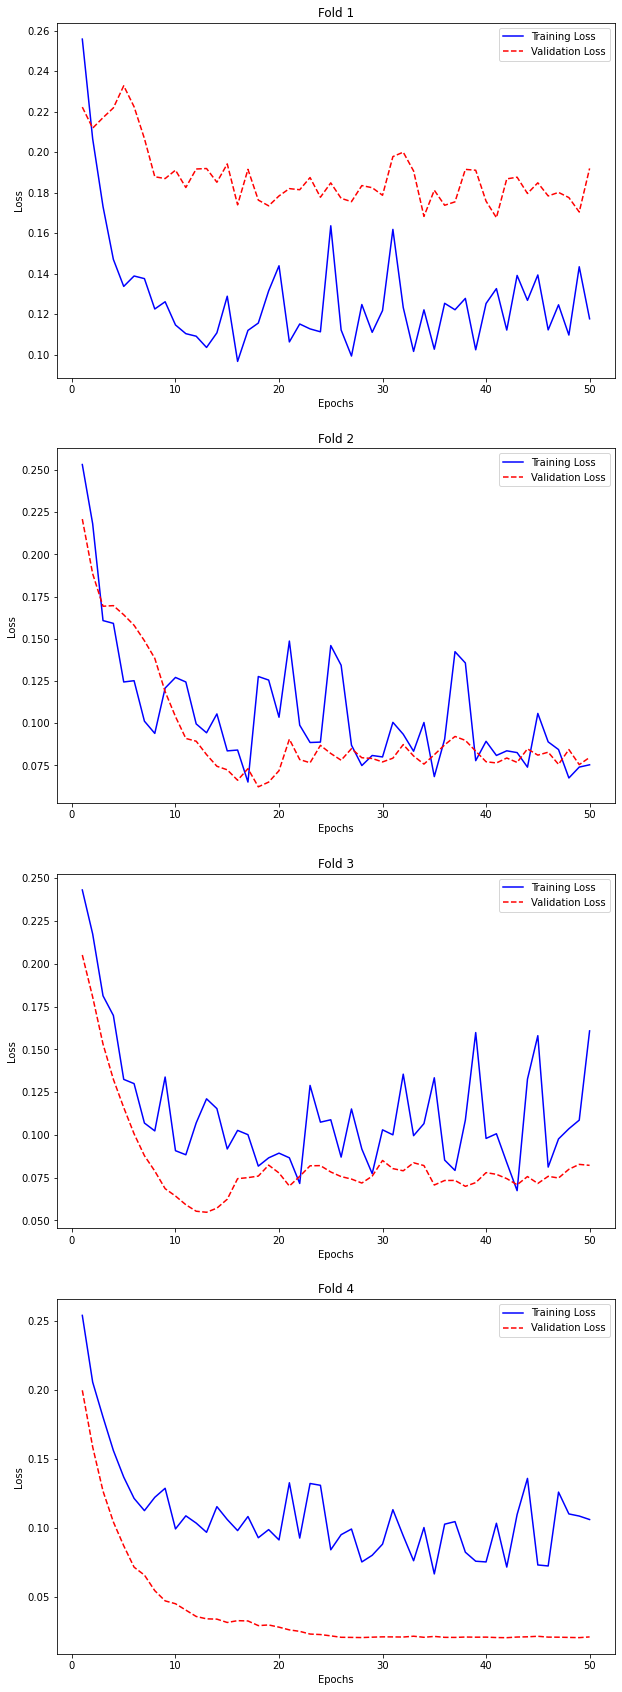

In [9]:
LP, Names, Network = train_fn(X=X, y=y, n_folds=cfg.n_folds, HL_Used=cfg.HL_1)

y_pred = eval_fn(Network, set(Names), ts_data, ts_data_setup.__len__())
print("Accuracy Score : {:.5f} %".format(accuracy_score(y_test, y_pred) * 100))
breaker()

LPV = []
LPT = []
for i in range(len(LP)):
  LPT.append(LP[i]["train"])
  LPV.append(LP[i]["valid"])

xAxis = [i+1 for i in range(cfg.epochs)]
plt.figure(figsize=(10, 30))
for fold in range(cfg.n_folds):
    plt.subplot(cfg.n_folds, 1, fold+1)
    plt.plot(xAxis, LPT[fold*cfg.epochs:(fold+1)*cfg.epochs], "b", label="Training Loss")
    plt.plot(xAxis, LPV[fold*cfg.epochs:(fold+1)*cfg.epochs], "r--", label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Fold {fold}".format(fold=fold+1))
plt.show()


------------------------------

Training ...

------------------------------

Processing Fold 1 ...
Epoch    27: reducing learning rate of group 0 to 1.0000e-04.
Epoch    31: reducing learning rate of group 0 to 1.0000e-05.
Epoch    35: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 2 ...
Epoch    16: reducing learning rate of group 0 to 1.0000e-04.
Epoch    23: reducing learning rate of group 0 to 1.0000e-05.
Epoch    27: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 3 ...
Epoch    21: reducing learning rate of group 0 to 1.0000e-04.
Epoch    25: reducing learning rate of group 0 to 1.0000e-05.
Epoch    29: reducing learning rate of group 0 to 1.0000e-06.
Processing Fold 4 ...
Epoch    25: reducing learning rate of group 0 to 1.0000e-04.
Epoch    29: reducing learning rate of group 0 to 1.0000e-05.
Epoch    33: reducing learning rate of group 0 to 1.0000e-06.

------------------------------

Time Taken to Train 4 folds for 50 epochs : 0.18 minutes

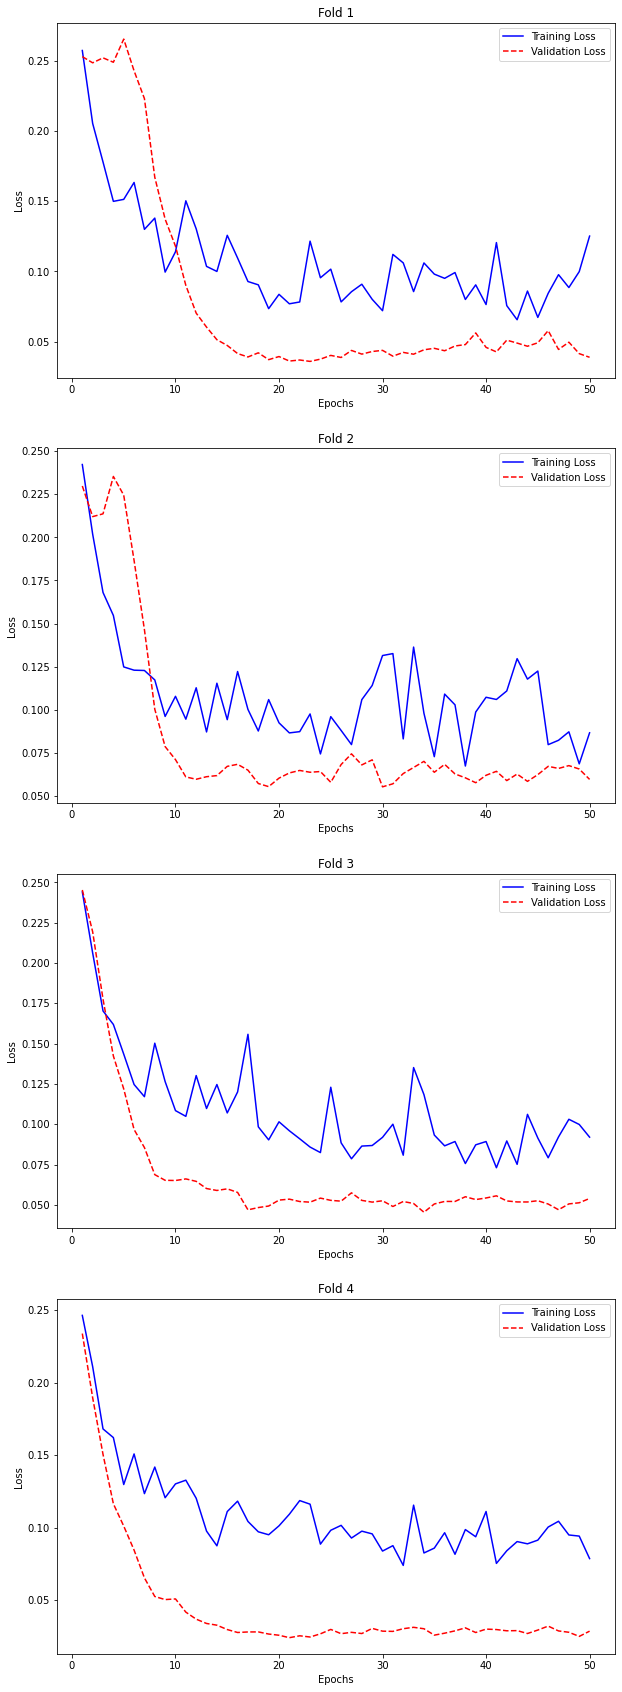

In [10]:
LP, Names, Network = train_fn(X=X, y=y, n_folds=cfg.n_folds, HL_Used=cfg.HL_2)

y_pred = eval_fn(Network, set(Names), ts_data, ts_data_setup.__len__())
print("Accuracy Score : {:.5f} %".format(accuracy_score(y_test, y_pred) * 100))
breaker()

LPV = []
LPT = []
for i in range(len(LP)):
  LPT.append(LP[i]["train"])
  LPV.append(LP[i]["valid"])

xAxis = [i+1 for i in range(cfg.epochs)]
plt.figure(figsize=(10, 30))
for fold in range(cfg.n_folds):
    plt.subplot(cfg.n_folds, 1, fold+1)
    plt.plot(xAxis, LPT[fold*cfg.epochs:(fold+1)*cfg.epochs], "b", label="Training Loss")
    plt.plot(xAxis, LPV[fold*cfg.epochs:(fold+1)*cfg.epochs], "r--", label="Validation Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Fold {fold}".format(fold=fold+1))
plt.show()

In [11]:
breaker()
print("Notebook Runtime : {:.2f} seconds".format(nb_start_time - time()))
breaker()


------------------------------

Notebook Runtime : -21.57 seconds

------------------------------

